## 샘플 데이터와 Stacking Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2021)

## 1. Data

### 1.1 Sample Data

In [2]:
from sklearn.datasets import make_regression

data, label = make_regression(n_samples=1000, n_features=20, n_informative=15, noise=0.1, random_state=1)

- n_samples: 샘플 데이터 수
- n_features: 변수의 수
- n_informative: 의미 변수

In [3]:
data.shape, label.shape

((1000, 20), (1000,))

### 1.2 EDA

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)

In [5]:
pca_data = pca.fit_transform(data)

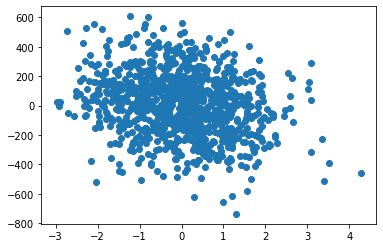

In [6]:
plt.scatter(pca_data, label)

### 1.3 Data Split

In [7]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_label, test_label = train_test_split(
    data, label, train_size=0.7, random_state=2021
)

## 2. 개별 모델의 성능

In [8]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [9]:
models = {
    'knn': KNeighborsRegressor(),
    'tree': DecisionTreeRegressor(),
    'svm': SVR(),
}

In [11]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

In [14]:
models.items()

dict_items([('knn', KNeighborsRegressor()), ('tree', DecisionTreeRegressor()), ('svm', SVR())])

In [13]:
names = []
results = []
for name, model in models.items():
    result = cross_val_score(model, train_data, train_label, cv=3, scoring='neg_mean_absolute_error')
    names += [name]
    results += [result]

- cv: K-fold 수

In [15]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

사이킷런에서 사용할 수 있는 점수들.

In [16]:
results

[array([-105.03162689, -105.83152462, -102.13684464]),
 array([-174.56490359, -157.39573567, -154.74981438]),
 array([-169.94710581, -171.22395842, -162.4710332 ])]

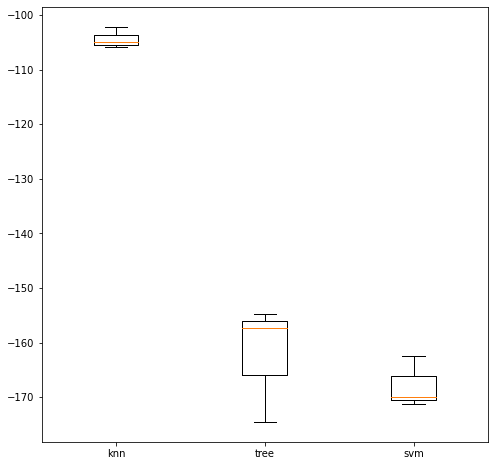

In [17]:
plt.figure(figsize=(8, 8))
plt.boxplot(results, labels=names)
plt.show()

KNN이 가장 예측을 잘 함.

In [18]:
for name, model in models.items():
    model.fit(train_data, train_label)
    test_pred = model.predict(test_data)
    acc = mean_absolute_error(test_label, test_pred)
    print(f"Model {name} test mean absolute error is {acc:.4}")

Model knn test mean absolute error is 97.77
Model tree test mean absolute error is 162.7
Model svm test mean absolute error is 162.6


## 3. Stacking

In [19]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

In [21]:
stacking = StackingRegressor(
    estimators=list(models.items()),
    final_estimator=LinearRegression(),
    cv=3
)

- estimators: stacking에서 사용할 모델들.
- final_estimator: Meta Model.
- cv: cross validation. Stacking에서 자체적으로 제공.

In [23]:
stacking_result = cross_val_score(stacking, train_data, train_label, cv=3, scoring='neg_mean_absolute_error')

In [24]:
stacking_result

array([-95.75597599, -83.79885798, -92.33185322])

In [25]:
all_result = []
all_result.extend(results)
all_result.append(stacking_result)

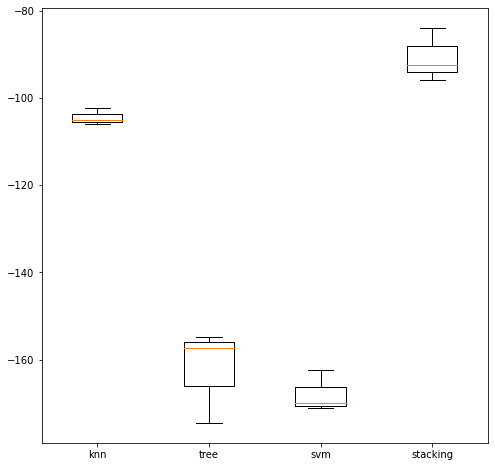

In [26]:
plt.figure(figsize=(8, 8))
plt.boxplot(all_result, labels=names + ['stacking'])
plt.show()

In [27]:
for name, model in models.items():
    test_pred = model.predict(test_data)
    acc = mean_absolute_error(test_label, test_pred)
    print(f"Model {name} test mean absolute error is {acc:.4}")
    
stacking.fit(train_data, train_label)
stacking_pred = stacking.predict(test_data)
stacking_mae = mean_absolute_error(test_label, stacking_pred)
print(f"Model stacking mean absolute error is {stacking_mae:.4}")

Model knn test mean absolute error is 97.77
Model tree test mean absolute error is 162.7
Model svm test mean absolute error is 162.6
Model stacking mean absolute error is 82.81
